### **本节介绍循环神经网络的实现**

**下面是循环神经网络的基本架构**

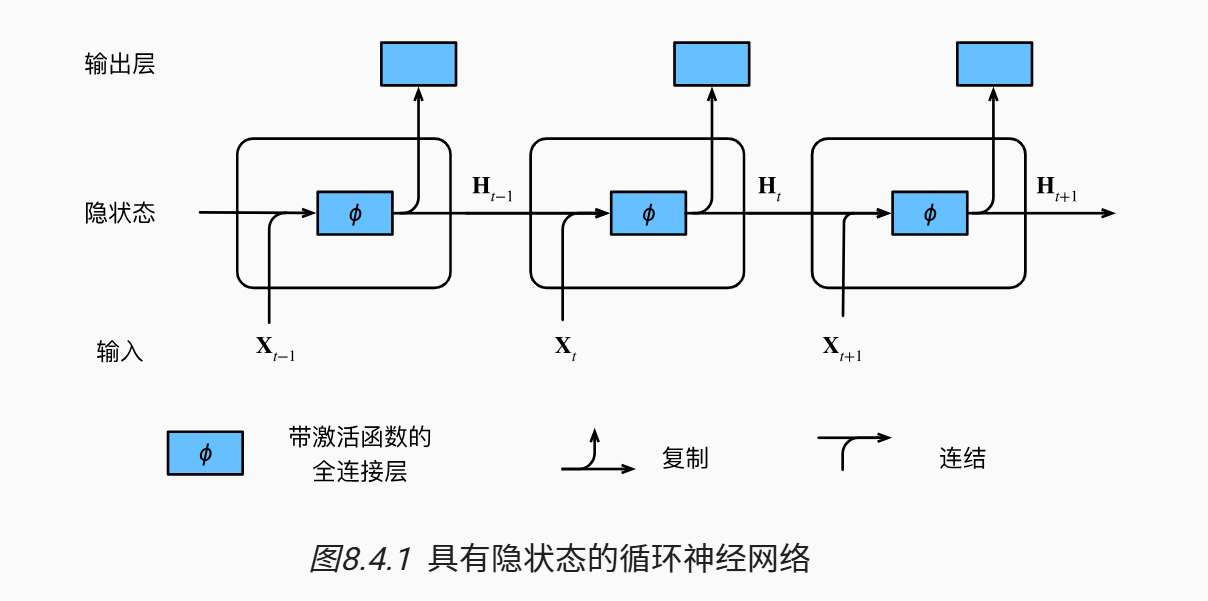

**隐状态的经典理解：隐状态作为一个持久存储器，为 RNN 的神经元提供了记忆！**

**一，基于循环神经网络的字符级语言模型的简单示意图**

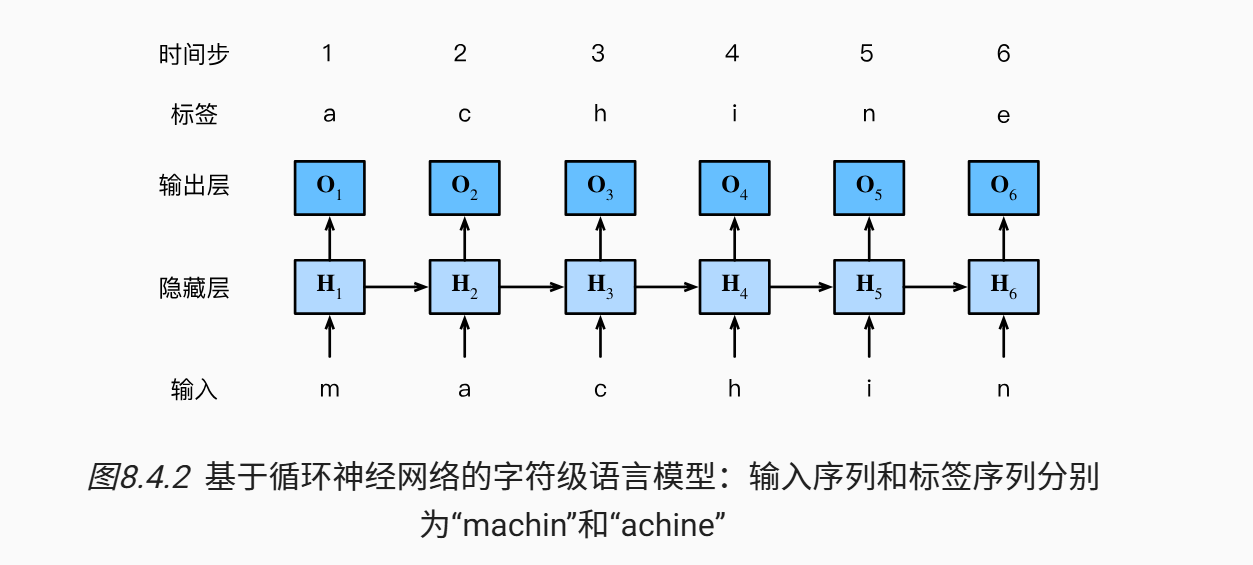

**下面这段话为教材原话，加深理解**

在训练过程中，我们对每个时间步的输出层的输出进行softmax操作， 然后利用交叉熵损失计算模型输出和标签之间的误差。 由于隐藏层中隐状态的循环计算， 图8.4.2中的第3
个时间步的输出$O_3$
 由文本序列“m”“a”和“c”确定。 由于训练数据中这个文本序列的下一个字符是“h”， 因此第3
个时间步的损失将取决于下一个字符的概率分布， 而下一个字符是基于特征序列“m”“a”“c”和这个时间步的标签“h”生成的。

在实践中，我们使用的批量大小为$n > 1$
， 每个词元都由一个$d$
维向量表示。 因此，在时间步$t$
输入$\textbf{\(X_t\)}$
将是一个$n \times d$
矩阵， 这与我们在 8.4.2节中的讨论相同。

**二，RNN的从零开始实现——实现字符级语言模型**

In [1]:
# 导入框架
import math
import torch
from torch import nn
from torch.nn import functional as F
# from d2l import torch as d2l
from net_frame import *

In [2]:
# 读取数据集
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
print(type(vocab))

<class 'net_frame.Vocab'>


In [3]:
for x,y in train_iter:
    print(x.shape)
    print(y.shape)
    print(x,y)
    break


torch.Size([32, 35])
torch.Size([32, 35])
tensor([[ 5, 13,  2,  ..., 15,  7,  6],
        [11, 20,  4,  ...,  8,  1, 21],
        [ 4,  6, 11,  ...,  8,  1,  7],
        ...,
        [ 6, 26, 14,  ...,  3, 21,  2],
        [ 8,  3,  4,  ...,  3,  1, 21],
        [ 2, 15,  9,  ...,  4,  6, 11]]) tensor([[13,  2,  1,  ...,  7,  6, 22],
        [20,  4,  8,  ...,  1, 21,  2],
        [ 6, 11,  1,  ...,  1,  7, 22],
        ...,
        [26, 14, 10,  ..., 21,  2, 16],
        [ 3,  4, 12,  ...,  1, 21,  2],
        [15,  9,  4,  ...,  6, 11,  1]])


In [4]:
print(len(vocab))
# 独热编码演示
label_one_hot = F.one_hot(torch.tensor([0, 2]), len(vocab))
print(label_one_hot)

28
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])


我们每次采样的(**小批量数据形状是二维张量：
（批量大小，时间步数）。**)
`one_hot`函数将这样一个小批量数据转换成三维张量，
张量的最后一个维度等于词表大小（`len(vocab)`）。
我们经常转换输入的维度，以便获得形状为
（时间步数，批量大小，词表大小）的输出。
这将使我们能够更方便地通过最外层的维度，
一步一步地更新小批量数据的隐状态。


In [5]:
# 测试
x = torch.arange(10).reshape(2,5)
x = F.one_hot(x.T,len(vocab))
print(x.shape)

torch.Size([5, 2, 28])


**下面是模型的初始化**

In [6]:
# 初始化参数
def get_params(vocab_size, num_hiddens, device):
    """初始化简单RNN模型参数"""
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 获取最初隐状态(全0状态)
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

**下面的`rnn`函数定义了如何在一个时间步内计算隐状态和输出**

In [11]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    # print(outputs[0].shape,len(outputs))
    return torch.cat(outputs, dim=0), (H,)

In [12]:
# 测试
x = torch.arange(10,dtype = torch.int64).reshape(2,5) # (批大小，时间步)
x = F.one_hot(x.T,len(vocab)) # 化为(时间步，批大小，词表大小)
x = x.to(torch.float32) # dtype : int64 -> float32 
device = try_gpu()
batch_size = 2
num_hiddens = 10
y,last_H = rnn(x,init_rnn_state(batch_size,num_hiddens,try_gpu()),get_params(len(vocab),num_hiddens,try_gpu()))
print(f"input shape : {x.shape}")
print(f"output_shape : {y.shape}")
print(f"Hiden state shape : {last_H[0].shape}")

input shape : torch.Size([5, 2, 28])
output_shape : torch.Size([10, 28])
Hiden state shape : torch.Size([2, 10])


**下面用一个类来包装这些函数**

**注意细节：语言模型每个token是确定的，映射到下标，所以输入数据的dtype = int，而函数one_hot()转化也仅支持int，要关注这个细节**

In [13]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        """__call__函数，可以通过类的实例来调用该函数，实现net的前向传播"""
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [14]:
# 构造输入
x = torch.arange(10,dtype = torch.int64).reshape(2,5) # 仅需构造(批大小，时间步)，不需要one_hot，后转化类里会做

# 生成网络
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(x.shape[0], d2l.try_gpu())
Y, new_state = net(x.to(d2l.try_gpu()), state) # 利用实例调用__call__函数
print(Y.shape,new_state[0].shape)

torch.Size([10, 28]) torch.Size([2, 512])


**下面开始预测的实现**

让我们[**首先定义预测函数来生成`prefix`之后的新字符**]，
其中的`prefix`是一个用户提供的包含多个字符的字符串。
在循环遍历`prefix`中的开始字符时，
我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。
这被称为*预热*（warm-up）期，
因为在此期间模型会自我更新（例如，更新隐状态），
但不会进行预测。
预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，
从而预测字符并输出它们。


In [ ]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    # print(len(outputs),outputs[0])
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # print(get_input().shape)
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # print(outputs)
    # print([vocab.idx_to_token[i] for i in outputs])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        # print(y.shape)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [20]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())
# 输出错误结果


1 3
torch.Size([1, 1])


'time traveller wihzv<unk>qlkz'

**下面介绍梯度裁剪（数学难理解）**

In [21]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))    # 求梯度的范数
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

**训练**

在训练模型之前，让我们[**定义一个函数在一个迭代周期内训练模型**]。
它与我们训练 :numref:`sec_softmax_scratch`模型的方式有三个不同之处。

1. 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。
1. 我们在更新模型参数之前裁剪梯度。
   这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。
1. 我们用困惑度来评价模型。如 :numref:`subsec_perplexity`所述，
   这样的度量确保了不同长度的序列具有可比性。

具体来说，当使用顺序分区时，
我们只在每个迭代周期的开始位置初始化隐状态。
由于下一个小批量数据中的第$i$个子序列样本
与当前第$i$个子序列样本相邻，
因此当前小批量数据最后一个样本的隐状态，
将用于初始化下一个小批量数据第一个样本的隐状态。
这样，存储在隐状态中的序列的历史信息
可以在一个迭代周期内流经相邻的子序列。
然而，在任何一点隐状态的计算，
都依赖于同一迭代周期中前面所有的小批量数据，
这使得梯度计算变得复杂。
为了降低计算量，在处理任何一个小批量数据之前，
我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，
因此需要为每个迭代周期重新初始化隐状态。
与 :numref:`sec_softmax_scratch`中的
`train_epoch_ch3`函数相同，
`updater`是更新模型参数的常用函数。
它既可以是从头开始实现的`d2l.sgd`函数，
也可以是深度学习框架中内置的优化函数。

In [93]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


**上面的过程让我们了解的RNN模型及其训练、推理过程，下面进行简洁实现**

In [22]:
batch_size, num_steps = 32, 35
train_iter,vocab = load_data_time_machine(batch_size,num_steps)

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens) # 以后可能有多层隐藏态

state = torch.zeros((1, batch_size, num_hiddens))
print(state.shape) # (隐藏层数量，批大小，隐藏单元数)

X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
print(Y.shape, state_new.shape)

torch.Size([1, 32, 256])
torch.Size([35, 32, 256]) torch.Size([1, 32, 256])


注：nn.RNN这个高级API不涉及输出层的计算，仅输出到每个时间步的隐状态，这些隐状态可以用作后续输出层的输入

`rnn_layer`只包含隐藏的循环层，我们还需要创建一个单独的输出层。


In [23]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [24]:
# 测试预测
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

In [25]:
predict_ch8('time traveller', 10, net, vocab, device)

1 3
torch.Size([1, 1])


'time travellerpppppppppp'

**训练同上，更换为对应的net即可**